## Working w/ missing data
This is Part I of missing data analysis. The notebook contains only the smallest amount of necessary information
to work with the missing values. The next notebook will contain much more techniques & advanced statistics.

- estimating replacement of missing data
- dealing with outliers

*This notebook contains key ideas from <a href="https://www.amazon.com/Regression-Analysis-Python-Luca-Massaron/dp/1785286315">Regression Analysis with Python</a>


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

%matplotlib inline
sns.set()

In [2]:
# replacing with zeros
example = np.array([1, 2, np.nan, 4, 5])
print(np.nan_to_num(example))

# replacing with mean
missing = np.isnan(example)
to_replace = np.mean(example[~missing])
example[missing] = to_replace
print(example)


[1. 2. 0. 4. 5.]
[1. 2. 3. 4. 5.]


In [3]:
# replacing with Imputer
imputer = SimpleImputer().fit_transform([example])
print(imputer)


[[1. 2. 3. 4. 5.]]


## Outliers

After the necessary transformation & making sure that all the data is correct - the only thing left is to take care of the
outliers.

<b>Rule of Thumb:</b> plot boxplots on each feature & calculate the IQR * 1.5 to detect outliers.

Sklearn provides two automatic anomaly detections: <b>EllipticEnvelope</b> and <b>OneCLassSVM</b>
(which I'll be experimenting with at the end)

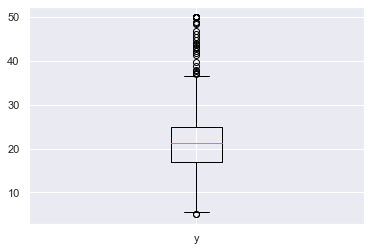

In [4]:
df = load_boston()
boston = pd.DataFrame(df.data, columns=df.feature_names)
boston['Price'] = df.target
labels = boston.columns

X = boston.iloc[:, :-1]
y = boston.iloc[:, -1]

# show the distribution of price
plt.boxplot(y, labels='y')
plt.show()

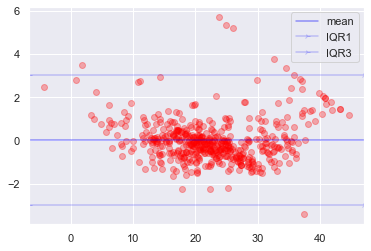

In [5]:
# calculate standardized residuals
import statsmodels.api as sm

Xsm = sm.add_constant(X)
model = sm.OLS(y, Xsm).fit()
standardized_residuals = model.get_influence().resid_studentized_internal

linreg = LinearRegression().fit(X, y)
y_pred = linreg.predict(X)
plt.plot(linreg.predict(X), standardized_residuals, 'wo', c='red', alpha=0.3)
plt.axhline(0, c='blue', label='mean', alpha=0.4)
plt.axhline(3, marker='4', c='blue', label='IQR1', alpha=0.2)
plt.axhline(-3, marker='4', c='blue', alpha=0.2, label='IQR3')
plt.legend()
plt.show()

# print(np.percentile((y - y_pred) / np.std(y), (25, 75)))
# print(iqr1, iqr3)


## Standardized residuals
The standardization process is tricky, it requires some work & understanding. Firstly, residuals are the differences
between original y & predicted values. To calculate them we need to use statsmodels.api and:
- <b>add constant to the features</b>
- fit & train the model
- get a hold of <b>.get_influence().resid_studentized_internal</b> which will give the final outcome.


## Outliers in predictors/features

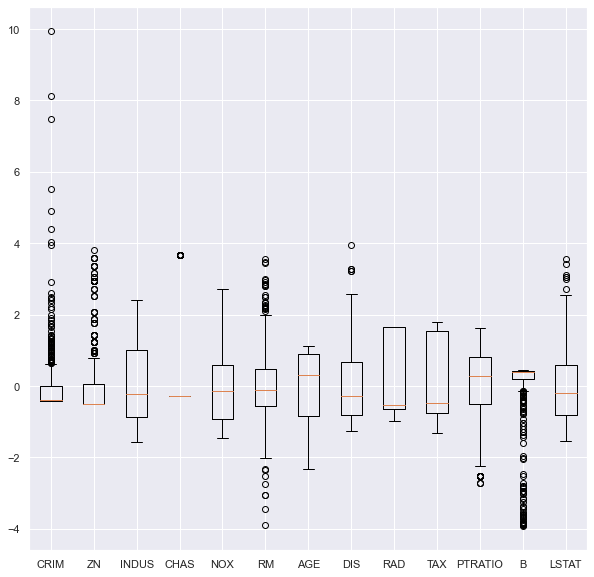

In [6]:
standardization = StandardScaler(with_std=True, with_mean=True)
Xs = standardization.fit_transform(X)
plt.figure(figsize=(10, 10))
plt.boxplot(Xs, labels=labels[:-1])
plt.show()

In [7]:
# unstandardized
# plt.figure(figsize=(10, 10))
# plt.boxplot(X, labels=labels[:-1])
# plt.show()

## PCA for regressions
PCA should be used mainly for variables which are strongly correlated. If the relationship is weak between variables,
PCA does not work well to reduce data. Refer to the correlation matrix to determine. In general, if most
of the correlation coefficients are smaller than 0.3, PCA will not help.

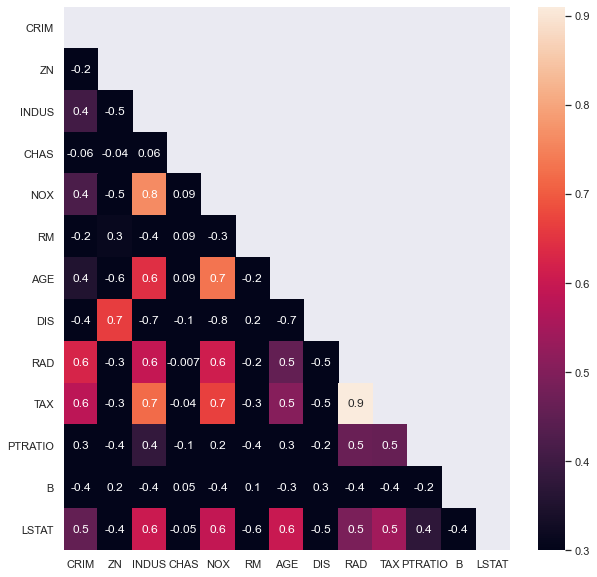

CRIM       0.222599
ZN        -0.087877
INDUS      0.245414
CHAS       0.074195
NOX        0.238346
RM        -0.068309
AGE        0.216201
DIS       -0.177023
RAD        0.283352
TAX        0.290357
PTRATIO    0.164979
B         -0.090879
LSTAT      0.208888
dtype: float64


In [8]:
mask = np.triu(X.corr())
plt.figure(figsize=(10, 10))
sns.heatmap(X.corr(), mask=mask, annot=True, fmt='.1g', vmin=0.3)
plt.show()

print(np.mean(X.corr()))

[0.47129606 0.11025193 0.0955859  0.06596732 0.06421661 0.05056978
 0.04118124 0.03046902 0.02130333 0.01694137 0.0143088  0.01302331
 0.00488533]


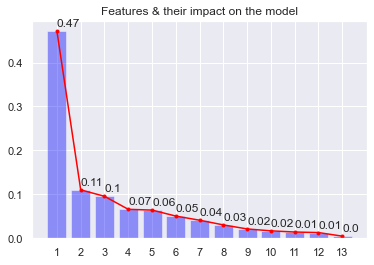

In [20]:
from sklearn.decomposition import PCA
pca = PCA().fit(Xs)
C = pca.transform(Xs)
print(pca.explained_variance_ratio_)

explained_variance = pca.explained_variance_ratio_
plt.title('Features & their impact on the model')
range_ = np.arange(1, len(explained_variance) + 1)
plt.bar(range_, explained_variance, color='blue', alpha=0.4, align='center')
plt.plot(range_, explained_variance, marker='.', color='red')

for pos, pct in enumerate(explained_variance):
    plt.annotate(str(round(pct, 2)), (pos+1, pct+0.01))
plt.xticks(range_)
plt.show()

Now, all we have to do is to plot the highest explained variances and see how they're plotted together


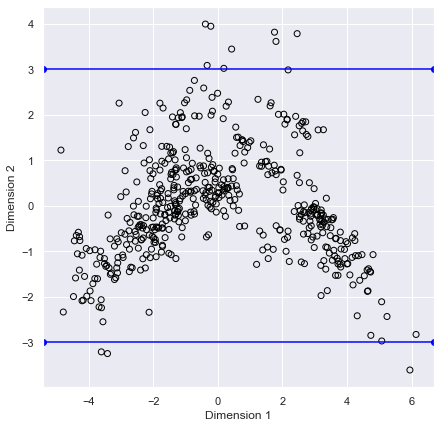

In [21]:
plt.figure(figsize=(7, 7))
plt.scatter(C[:, 0], C[:, 1], facecolors='none', edgecolors='black')
plt.axhline(-3, color='blue', marker='o')
plt.axhline(3, color='blue', marker='o')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

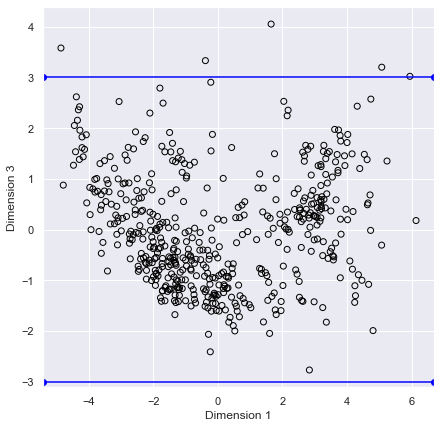

In [22]:
plt.figure(figsize=(7, 7))
plt.scatter(C[:, 0], C[:, 2], facecolors='none', edgecolors='black')
plt.axhline(-3, color='blue', marker='o')
plt.axhline(3, color='blue', marker='o')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 3')
plt.show()

## Removing | Replacing outliers
Three possibilities of its occurrence:
-  they're actually part of the model & give some irreplaceable insights. Solution: increase sample size or remove | resample
-  data preprocessing errors. Solution: remove them
-  faulty input. Solution: make the outliers as missing values & redo the whole operation

c:\users\dinar\appdata\local\programs\python\python38\lib\site-packages\matplotlib\collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


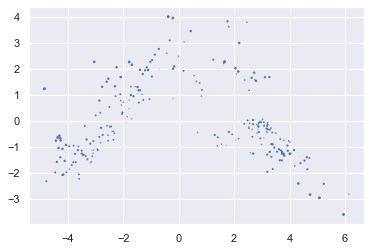

In [23]:
plt.scatter(C[:, 0], C[:, 1], C[:, 2])


# pca = PCA(n_components=3).fit(Xs)
# pca.explained_variance_ratio_